# Document AI Specialized Parser with Human in the Loop
This notebook shows you how use Document AI's specialized parsers ex. Invoice, Receipt, and W9

In [7]:
# Install necessary Python libraries and restart your kernel after.
!python -m pip install -r ../requirements.txt

In [8]:
from google.cloud import documentai_v1beta3 as documentai
from PIL import Image, ImageDraw

import os
import pandas as pd
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="DocAI_SA_Key.json"

## Set your processor variables 

In [9]:
PROJECT_ID = "crucial-haiku-321308"
LOCATION = "us"  # Format is 'us' or 'eu'
PROCESSOR_ID = "bc38b6cb7a56f539"  # Create processor in Cloud Console
PDF_PATH = "../resources/procurement/receipts/nike001.pdf" # Update to path of target document

The following code calls the synchronous API and parses the form fields and values.

In [10]:
def process_document_sample():
    # Instantiates a client
    client_options = {"api_endpoint": "{}-documentai.googleapis.com".format(LOCATION)}
    client = documentai.DocumentProcessorServiceClient(client_options=client_options)

    # The full resource name of the processor, e.g.:
    # projects/project-id/locations/location/processor/processor-id
    # You must create new processors in the Cloud Console first
    name = f"projects/{PROJECT_ID}/locations/{LOCATION}/processors/{PROCESSOR_ID}"

    with open(PDF_PATH, "rb") as image:
        image_content = image.read()

    # Read the file into memory
    document = {"content": image_content, "mime_type": "application/pdf"}

    # Configure the process request
    request = {"name": name, "document": document}

    # Recognizes text entities in the PDF document
    result = client.process_document(request=request)
    document = result.document
    entities = document.entities
    print("Document processing complete.\n\n")

    # For a full list of Document object attributes, please reference this page: https://googleapis.dev/python/documentai/latest/_modules/google/cloud/documentai_v1beta3/types/document.html#Document  
    types = []
    values = []
    confidence = []
    
    # Grab each key/value pair and their corresponding confidence scores.
    for entity in entities:
        types.append(entity.type_)
        values.append(entity.mention_text)
        confidence.append(round(entity.confidence,4))
        
    # Create a Pandas Dataframe to print the values in tabular format. 
    df = pd.DataFrame({'Type': types, 'Value': values, 'Confidence': confidence})
    display(df)
    
    if result.human_review_operation:
        print ("Triggered HITL long running operation: {}".format(result.human_review_operation))

    return document

In [11]:
doc = process_document_sample()

Document processing complete.




,Type,Value,Confidence
0,currency,179.10\n,1.0000
1,line_item,DA0484-013 M\nAS W NP 365 TIGHT 7/8 HI RISE\n1...,1.0000
2,line_item,AS W NK DF INDY LOGO CUT BRA\n1 pces X 55.00\n...,1.0000
3,line_item,AS M NSW SPE WN UL CARGO SHOR\n1 pces X 79.00\...,1.0000
4,net_amount,167.38,0.6877
5,purchase_time,5:49 PM\n,1.0000
6,receipt_date,26-07-21 5:49 PM\n,1.0000
7,supplier_address,3 Temasek Boulevard\n#01-375/376/377 Suntec Ci...,0.9500
8,supplier_city,,1.0000
9,supplier_name,,1.0000


## Draw the bounding boxes¶
We will now use the spatial data returned by the processor to mark our values on the invoice pdf file that we first converted into a jpg.

In [6]:
JPG_PATH = "../resources/procurement/invoices/invoice.jpg" # Update to path of a jpg of your sample document.

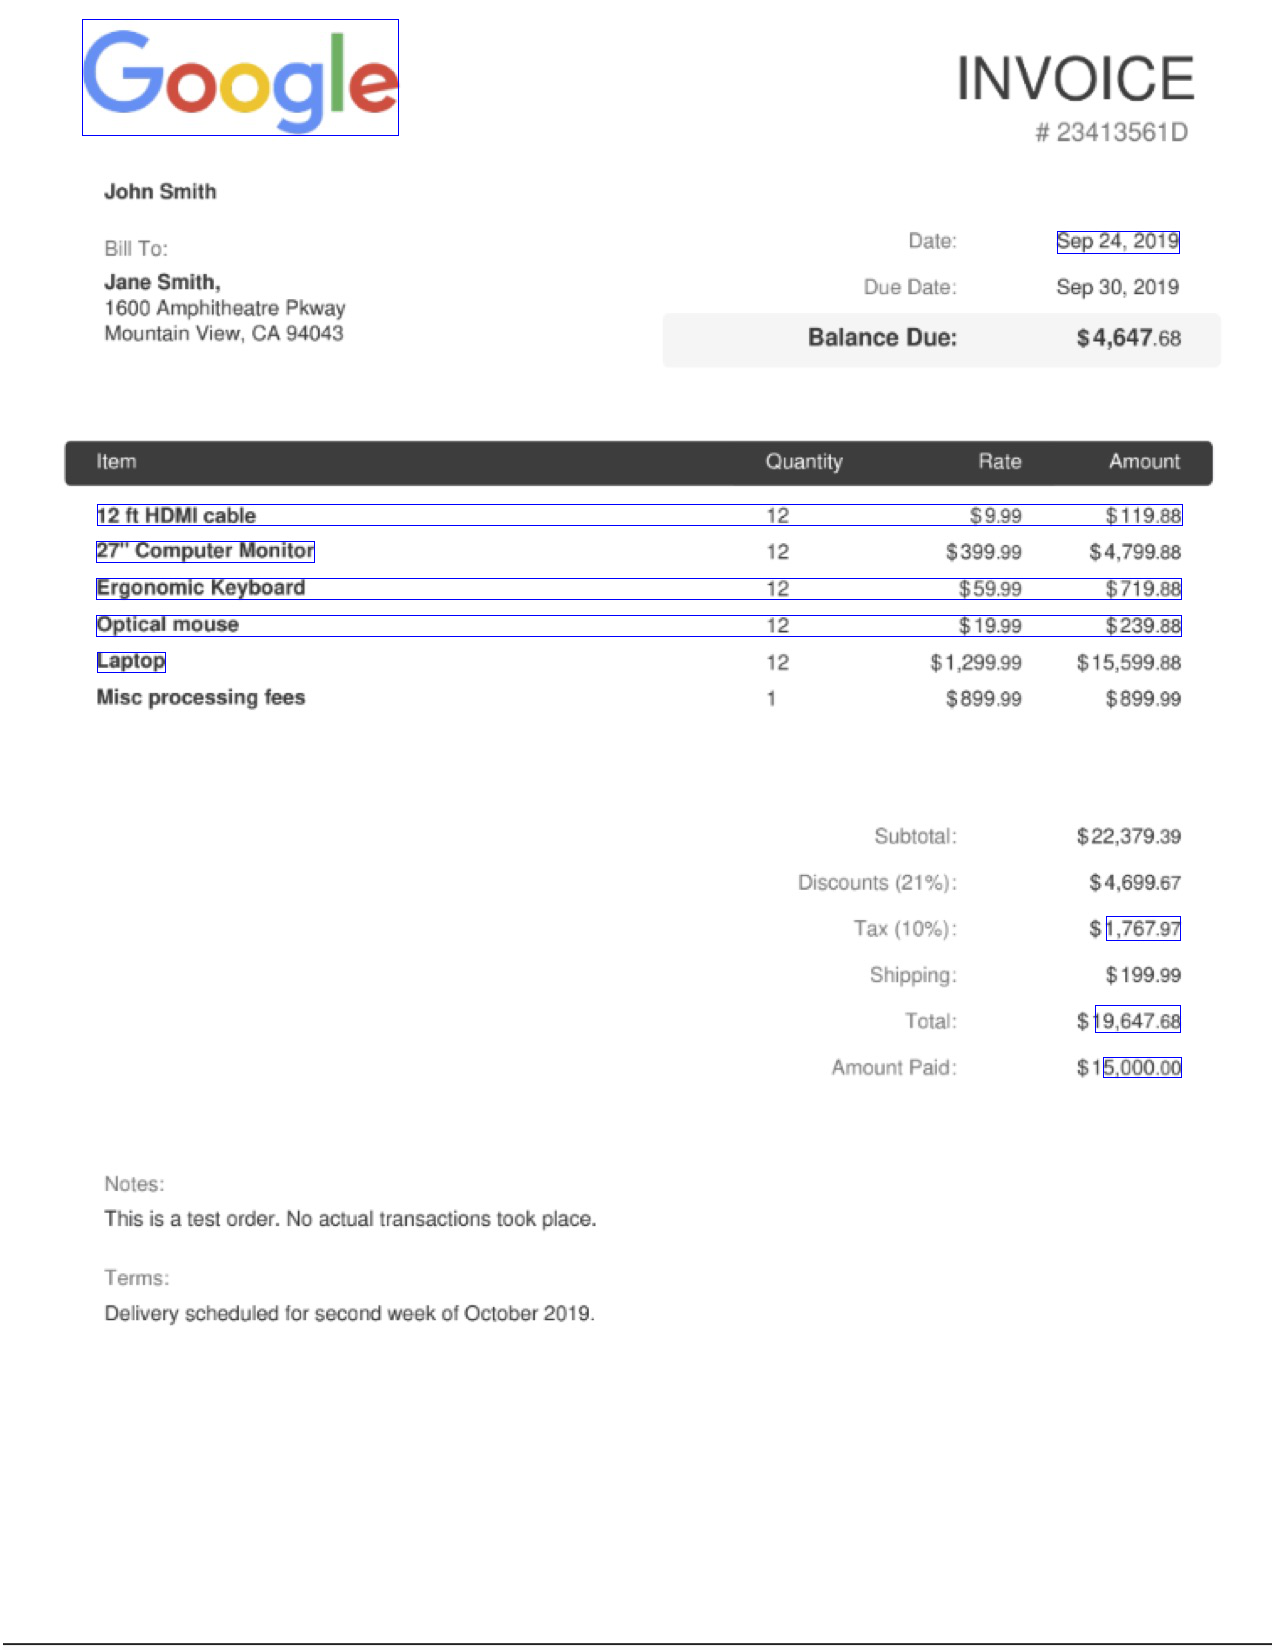

In [14]:
document_image = Image.open(JPG_PATH)
draw = ImageDraw.Draw(document_image)
for entity in doc.entities:
    # Draw the bounding box around the entities
    vertices = []
    for vertex in entity.page_anchor.page_refs[0].bounding_poly.normalized_vertices:
        vertices.append({'x': vertex.x * document_image.size[0], 'y': vertex.y * document_image.size[1]})
    draw.polygon([
        vertices[0]['x'], vertices[0]['y'],
        vertices[1]['x'], vertices[1]['y'],
        vertices[2]['x'], vertices[2]['y'],
        vertices[3]['x'], vertices[3]['y']], outline='blue')
document_image

# Human in the loop (HITL) Operation

**Only complete this section if a HITL Operation is triggered.** </br>

In [ ]:
lro = "LONG_RUNNING_OPERATION" # LRO printed in the previous cell ex. projects/660199673046/locations/us/operations/174674963333130330

In [ ]:
client = documentai.DocumentProcessorServiceClient()
operation = client._transport.operations_client.get_operation(lro)
if operation.done:
    print("HITL location: {} ".format(str(operation.response.value)[5:-1]))
else:
    print('Waiting on human review.')

In [ ]:
!gsutil cp "HITL_LOCATION" response.json # Location printed above ex. gs://gcs_bucket/receipt-output/174674963333130330/data-00001-of-00001.json

In [ ]:
with open("response.json", "r") as file:
    import json
    entities = {}
    data = json.load(file)
    for entity in data['entities']:
        if 'mentionText' in entity:
            entities[entity['type']] = entity['mentionText']
        else:
            entities[entity['type']] = ""
    
    for t in entities:
        print("{} : {}\n ".format(t, entities[t]))